In [1]:
import os,time

from os import listdir
from os.path import isfile, join, exists

from importlib import reload

import torch
import torchaudio,torchvision
from torch import optim
import torch.nn.functional as F
from torchvision import transforms,datasets
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, ToPILImage
from PIL import Image
import pandas as pd
import torch.nn as nn
import numpy as np
from sklearn import metrics
from utils import *
from NN import *
import random
import torchviz
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt

In [2]:
device

'cuda'

In [3]:
torch.manual_seed(42)
undersample = True

In [4]:
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = "cpu"

In [5]:
bird_data = pd.read_csv("./warblrb10k_public_metadata.csv")

In [6]:
def test(model, dataset):
    pass

In [7]:
#sampling_rate = 16000 # 77 cnn - 76 mlp
sampling_rate = 8000 # 79.1 cnn - 75.9 mlp - 76.6 lstm - 84.3 spectrogram cnn
#sampling_rate = 44100 # 77 cnn - 69.9 mlp

In [8]:
audio_dataset = AudioDataset(bird_data, dir_path="./wav/", sampling_rate=sampling_rate, undersample=undersample)
train_set, val_set = torch.utils.data.random_split(audio_dataset, [int(0.8*len(audio_dataset)), int(0.2*len(audio_dataset))])

Data has been resampled, New labels :  0.0    1955
1.0    1955
Name: hasbird, dtype: int64


In [9]:
bird_test_data = pd.read_csv("./test2/ff1010bird_metadata.csv")
audio_test_dataset = AudioDataset(bird_test_data, dir_path="./test2/wav/", sampling_rate=sampling_rate)

In [10]:
audio_test_dataset.get_stats()

0.0    5755
1.0    1935
Name: hasbird, dtype: int64


In [11]:
5755 / (5755 + 1935)

0.7483745123537061

In [12]:
generate_all_spectrograms(audio_dataset, sampling_rate)

In [13]:
generate_all_waveforms(audio_dataset, sampling_rate)

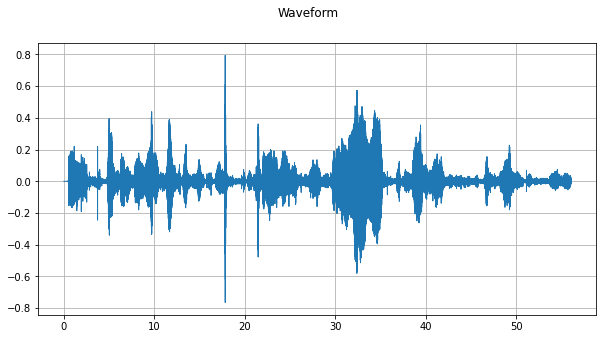

Spectrogram Shape, channels, frames :  (1, 448512) 1 448512
[[1.82432333e-14 3.30975833e-15 1.26193404e-14 ... 1.42537533e-08
  3.66701892e-09 1.97465650e-08]
 [6.29044983e-14 4.80773786e-14 4.41606221e-15 ... 5.85353111e-07
  3.52616800e-07 6.17652490e-08]
 [4.20191317e-14 1.55477279e-14 5.46760017e-14 ... 2.60697341e-06
  1.91754072e-06 2.74792108e-07]
 ...
 [1.49015753e-14 1.75691993e-13 1.47232582e-13 ... 5.67461971e-14
  2.79801311e-13 1.36391506e-13]
 [8.74675071e-15 3.65452290e-14 8.00840309e-14 ... 1.43462724e-13
  8.03403337e-15 8.27473359e-14]
 [8.40629956e-15 5.65860180e-15 1.90278168e-14 ... 4.11850062e-15
  2.59374066e-17 2.91384218e-15]]


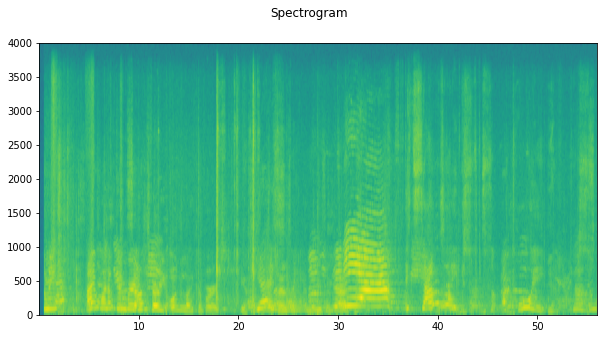

Bird :  0.0


In [14]:
audio_dataset.display()

In [15]:
audio_dataset.get_stats()

0.0    1955
1.0    1955
Name: hasbird, dtype: int64


In [16]:
train_set[0]

(tensor([-4.7475e-06, -2.3319e-06, -1.4075e-05,  ...,  6.6924e-04,
         -4.0542e-04, -2.0209e-03]),
 0.0)

In [17]:
spectrogram_dataset = ImageDataset(bird_data, "./spectrogram/", undersample=undersample)
spec_train_set, spec_val_set = torch.utils.data.random_split(spectrogram_dataset, [int(0.8*len(spectrogram_dataset)), int(0.2*len(spectrogram_dataset))])

Data has been resampled, New labels :  0.0    1955
1.0    1955
Name: hasbird, dtype: int64


In [18]:
spectrogram_dataset.display()

torch.Size([4, 288, 432])
Bird :  1.0


In [19]:
waveform_dataset = ImageDataset(bird_data, "./waveform/", undersample=undersample)
wave_train_set, wave_val_set = torch.utils.data.random_split(waveform_dataset, [int(0.8*len(waveform_dataset)), int(0.2*len(waveform_dataset))])

Data has been resampled, New labels :  0.0    1955
1.0    1955
Name: hasbird, dtype: int64


In [20]:
waveform_dataset.display()

torch.Size([4, 288, 432])
Bird :  0.0


## Training Sets

In [21]:
counts = train_set.dataset.y_train.loc[train_set.indices].value_counts()
counts

0.0    1593
1.0    1535
Name: hasbird, dtype: int64

In [22]:
counts[1] / counts.sum()

0.4907289002557545

In [23]:
counts = spec_train_set.dataset.y_train.loc[spec_train_set.indices].value_counts()
counts

1.0    1579
0.0    1549
Name: hasbird, dtype: int64

In [24]:
counts[1] / counts.sum()

0.5047953964194374

## Validation Sets

In [25]:
counts = val_set.dataset.y_train.loc[val_set.indices].value_counts()
counts

1.0    420
0.0    362
Name: hasbird, dtype: int64

In [26]:
counts[1] / counts.sum()

0.5370843989769821

In [27]:
counts = spec_val_set.dataset.y_train.loc[spec_val_set.indices].value_counts()
counts

0.0    406
1.0    376
Name: hasbird, dtype: int64

In [28]:
counts[1] / counts.sum()

0.48081841432225064

## CNN

### Amplitude Based CNN

In [29]:
cnn_model = CNNModel(1).to(device)

In [34]:
cnn_model

CNNModel(
  (conv_block1): ConvBlock1d(
    (conv1): Conv1d(1, 10, kernel_size=(5,), stride=(1,))
    (max_pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): ConvBlock1d(
    (conv1): Conv1d(10, 20, kernel_size=(5,), stride=(1,))
    (max_pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): ConvBlock1d(
    (conv1): Conv1d(20, 30, kernel_size=(5,), stride=(1,))
    (max_pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block4): ConvBlock1d(
    (conv1): Conv1d(30, 60, kernel_size=(5,), stride=(1,))
    (max_pool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=660, out_features=1250, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=1250, out_features=625, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.25, inpl

In [35]:
#torchviz.make_dot(cnn_model(torch.rand((1, sampling_rate)).to(device)))

In [38]:
loss, accuracy, val_loss, val_accuracy = train(cnn_model, train_set, val_set, 15, 0.0001, 0)

Epoch: 1/15 -- [1400/3128 (100.0%)]	Loss: 0.6188519549369812	Accuracy: 0.650	Time taken: 91.53125	Validation Loss: 3.715548038482666 || Validation Accuracy: 0.467
Epoch: 2/15 -- [1400/3128 (100.0%)]	Loss: 0.6138862895965577	Accuracy: 0.645	Time taken: 91.078125	Validation Loss: 3.9162604808807373 || Validation Accuracy: 0.468
Epoch: 3/15 -- [1400/3128 (100.0%)]	Loss: 0.6148868608474731	Accuracy: 0.646	Time taken: 91.34375	Validation Loss: 4.303960800170898 || Validation Accuracy: 0.468
Epoch: 4/15 -- [1400/3128 (100.0%)]	Loss: 0.6154898500442505	Accuracy: 0.653	Time taken: 90.84375	Validation Loss: 4.471328258514404 || Validation Accuracy: 0.465
Epoch: 5/15 -- [1400/3128 (100.0%)]	Loss: 0.6153716039657593	Accuracy: 0.652	Time taken: 92.625	Validation Loss: 4.677859783172607 || Validation Accuracy: 0.465
Epoch: 6/15 -- [1400/3128 (100.0%)]	Loss: 0.613341567516327	Accuracy: 0.645	Time taken: 93.734375	Validation Loss: 4.2704572677612305 || Validation Accuracy: 0.467
Epoch: 7/15 -- [1400/

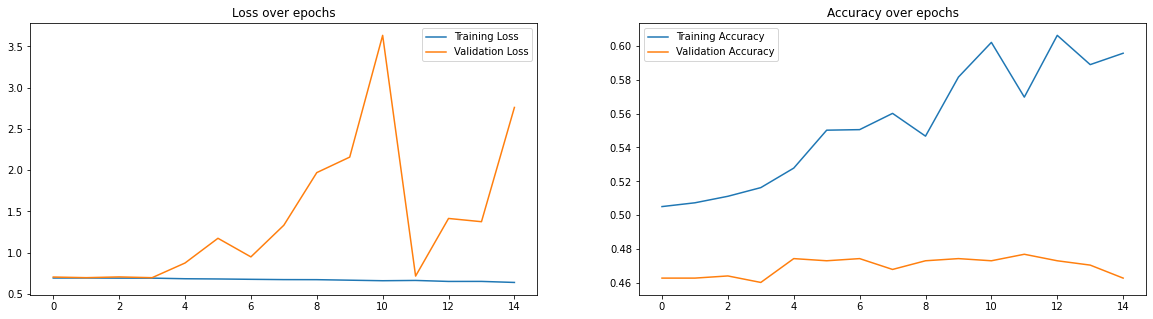

In [37]:
plot_loss_acc(loss, accuracy, val_loss, val_accuracy, "CNN_Amplitude_Loss_Acc_1_{}".format(int(undersample)))

In [34]:
torch.onnx.export(cnn_model, torch.rand((1,8000)).to(device), "cnn_model.onnx")

### Spectrogram Based CNN

In [29]:
spec_cnn_model = SpecCNNModel(3).to(device)

In [30]:
spec_cnn_model

SpecCNNModel(
  (conv_block1): ConvBlock2d(
    (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (max_pool): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): ConvBlock2d(
    (conv1): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
    (max_pool): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): ConvBlock2d(
    (conv1): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
    (max_pool): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block4): ConvBlock2d(
    (conv1): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
    (max_pool): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=480, out_features=1250, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=1250, out_features=6

In [31]:
loss, accuracy, val_loss, val_accuracy = train(spec_cnn_model, spec_train_set, spec_val_set, 15, 0.001, 0)

Epoch: 1/15 -- [1400/3128 (100.0%)]	Loss: 0.668638870716095	Accuracy: 0.595	Time taken: 86.59375	Validation Loss: 0.6621255874633789 || Validation Accuracy: 0.556
Epoch: 2/15 -- [1400/3128 (100.0%)]	Loss: 0.6230553269386292	Accuracy: 0.652	Time taken: 82.90625	Validation Loss: 0.5226328372955322 || Validation Accuracy: 0.708
Epoch: 3/15 -- [1400/3128 (100.0%)]	Loss: 0.5433150029182434	Accuracy: 0.715	Time taken: 82.65625	Validation Loss: 0.5101150274276733 || Validation Accuracy: 0.694
Epoch: 4/15 -- [1400/3128 (100.0%)]	Loss: 0.5065072965621948	Accuracy: 0.730	Time taken: 81.828125	Validation Loss: 0.5169529318809509 || Validation Accuracy: 0.746
Epoch: 5/15 -- [1400/3128 (100.0%)]	Loss: 0.4964734756946564	Accuracy: 0.733	Time taken: 81.3125	Validation Loss: 0.5165257453918457 || Validation Accuracy: 0.733
Epoch: 6/15 -- [1400/3128 (100.0%)]	Loss: 0.49156880617141724	Accuracy: 0.740	Time taken: 84.859375	Validation Loss: 0.46599081158638 || Validation Accuracy: 0.776
Epoch: 7/15 -- [1

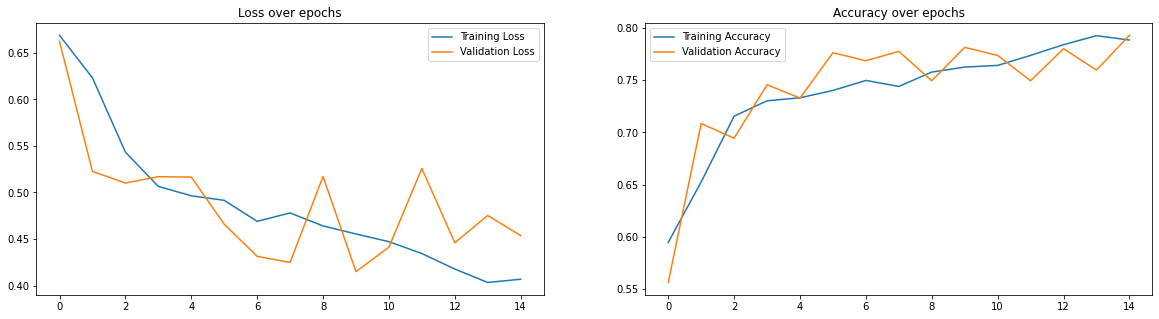

In [32]:
plot_loss_acc(loss, accuracy, val_loss, val_accuracy, "CNN_Spec_Loss_Acc_1_{}".format(int(undersample)))

### Waveform Based CNN

In [29]:
wave_cnn_model = SpecCNNModel(3).to(device)

In [30]:
wave_cnn_model

SpecCNNModel(
  (conv_block1): ConvBlock2d(
    (conv1): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (max_pool): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): ConvBlock2d(
    (conv1): Conv2d(10, 20, kernel_size=(3, 3), stride=(1, 1))
    (max_pool): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): ConvBlock2d(
    (conv1): Conv2d(20, 30, kernel_size=(3, 3), stride=(1, 1))
    (max_pool): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block4): ConvBlock2d(
    (conv1): Conv2d(30, 60, kernel_size=(3, 3), stride=(1, 1))
    (max_pool): MaxPool2d(kernel_size=(3, 3), stride=(3, 3), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=480, out_features=1250, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.25, inplace=False)
    (3): Linear(in_features=1250, out_features=6

In [31]:
loss, accuracy, val_loss, val_accuracy = train(wave_cnn_model, wave_train_set, wave_val_set, 15, 0.001, 0)

Epoch: 1/15 -- [1400/3128 (100.0%)]	Loss: 0.6692047691345215	Accuracy: 0.598	Time taken: 70.796875	Validation Loss: 0.6424047946929932 || Validation Accuracy: 0.661
Epoch: 2/15 -- [1400/3128 (100.0%)]	Loss: 0.6112159776687622	Accuracy: 0.672	Time taken: 69.359375	Validation Loss: 0.5993016958236694 || Validation Accuracy: 0.668
Epoch: 3/15 -- [1400/3128 (100.0%)]	Loss: 0.5891463088989258	Accuracy: 0.688	Time taken: 68.265625	Validation Loss: 0.5966388583183289 || Validation Accuracy: 0.682
Epoch: 4/15 -- [1400/3128 (100.0%)]	Loss: 0.5741986906528473	Accuracy: 0.703	Time taken: 67.953125	Validation Loss: 0.5825252532958984 || Validation Accuracy: 0.671
Epoch: 5/15 -- [1400/3128 (100.0%)]	Loss: 0.566674827337265	Accuracy: 0.703	Time taken: 68.4375	Validation Loss: 0.5958230495452881 || Validation Accuracy: 0.665
Epoch: 6/15 -- [1400/3128 (100.0%)]	Loss: 0.5457070004940033	Accuracy: 0.706	Time taken: 69.484375	Validation Loss: 0.5890263319015503 || Validation Accuracy: 0.682
Epoch: 7/15 -

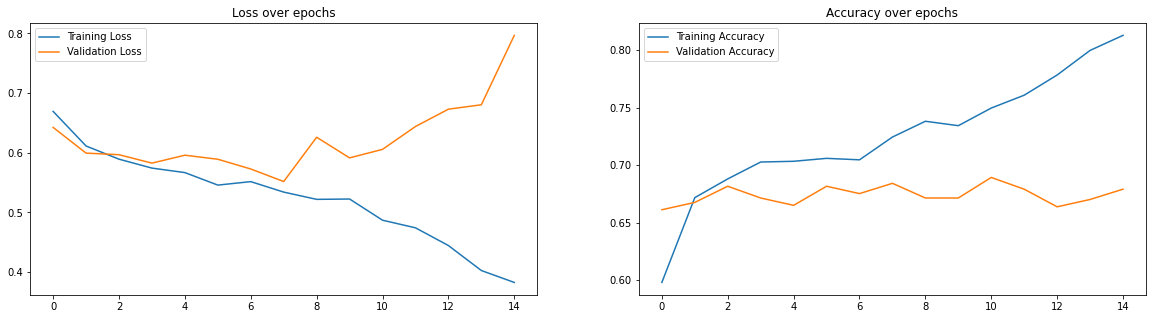

In [33]:
plot_loss_acc(loss, accuracy, val_loss, val_accuracy, "CNN_Waveform_Loss_Acc_1_{}".format(int(undersample)))

In [23]:
waveform_dataset.get_image(0).shape

torch.Size([3, 288, 432])

In [26]:
torch.onnx.export(wave_cnn_model, torch.rand((1,3,288,432)).to(device), "cnn_waveform_model.onnx")

Input Shape :  torch.Size([1, 3, 288, 432])


## LSTM

In [29]:
input_length = sampling_rate
input_size = 1
batch_size = 64
num_layers = 1
#hidden_size = int(sampling_rate / 20)
hidden_size = 100
lstm_model = LSTMModel(input_size, hidden_size, num_layers).to(device)

In [30]:
lstm_model

LSTMModel(
  (lstm): LSTM(1, 100, batch_first=True)
  (classifier): Sequential(
    (0): Linear(in_features=100, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [31]:
loss, accuracy, val_loss, val_accuracy = train_lstm(lstm_model, train_set, val_set, 15, 0.001, batch_size=batch_size, num_layers=num_layers, hidden_size=hidden_size, augmentation_prob=0)

Epoch: 1/15 -- [2744/3128 (100.0%)]	Loss: 0.6935954957592244	Accuracy: 0.495	Time taken: 110.890625	Validation Loss: 0.6945903301239014 || Validation Accuracy: 0.463
Epoch: 2/15 -- [2744/3128 (100.0%)]	Loss: 0.6931266967131167	Accuracy: 0.509	Time taken: 115.6875	Validation Loss: 0.6952401399612427 || Validation Accuracy: 0.463
Epoch: 3/15 -- [2744/3128 (100.0%)]	Loss: 0.6932233438199881	Accuracy: 0.509	Time taken: 112.9375	Validation Loss: 0.6936200261116028 || Validation Accuracy: 0.463
Epoch: 4/15 -- [2744/3128 (100.0%)]	Loss: 0.6930764208034593	Accuracy: 0.509	Time taken: 113.40625	Validation Loss: 0.6947442889213562 || Validation Accuracy: 0.463
Epoch: 5/15 -- [2744/3128 (100.0%)]	Loss: 0.6931975386580642	Accuracy: 0.501	Time taken: 110.140625	Validation Loss: 0.6954883933067322 || Validation Accuracy: 0.463
Epoch: 6/15 -- [2744/3128 (100.0%)]	Loss: 0.6930410728162649	Accuracy: 0.509	Time taken: 113.671875	Validation Loss: 0.6960393190383911 || Validation Accuracy: 0.463
Epoch: 7/

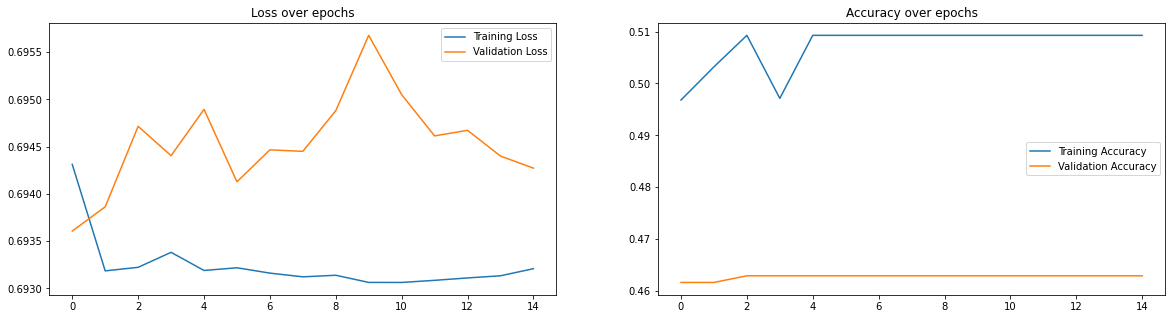

In [32]:
plot_loss_acc(loss, accuracy, val_loss, val_accuracy, "LSTM_Loss_Acc_2_{}".format(int(undersample)))

In [37]:
#torch.save(lstm_model.state_dict(), "lstm_model.onnx")
hidden = (torch.zeros((1, hidden_size)).to(device), torch.zeros((1, hidden_size)).to(device))
torch.onnx.export(lstm_model, (torch.rand((8000, 1)).to(device), hidden), "lstm_model.onnx")

c:\Users\Alexis\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\onnx\symbolic_opset9.py:4315: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(
c:\Users\Alexis\AppData\Local\Programs\Python\Python38\lib\site-packages\torch\onnx\_internal\jit_utils.py:258: UserWarning: The shape inference of prim::Constant type is missing, so it may result in wrong shape inference for the exported graph. Please consider adding it in symbolic function. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\jit\passes\onnx\shape_type_inference.cpp:1888.)
  _C._jit_pass_onnx_node_shape_type_inference(node, params_dict, opset_version)
c:\Users\Alexis\AppData\Local\Programs\Python\Python38\lib

## MLP

In [27]:
mlp_model = MLPModel(sampling_rate).to(device)

In [28]:
mlp_model

MLPModel(
  (fc1): Linear(in_features=8000, out_features=2000, bias=True)
  (fc2): Linear(in_features=2000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=500, bias=True)
  (fc4): Linear(in_features=500, out_features=250, bias=True)
  (fc5): Linear(in_features=250, out_features=1, bias=True)
)

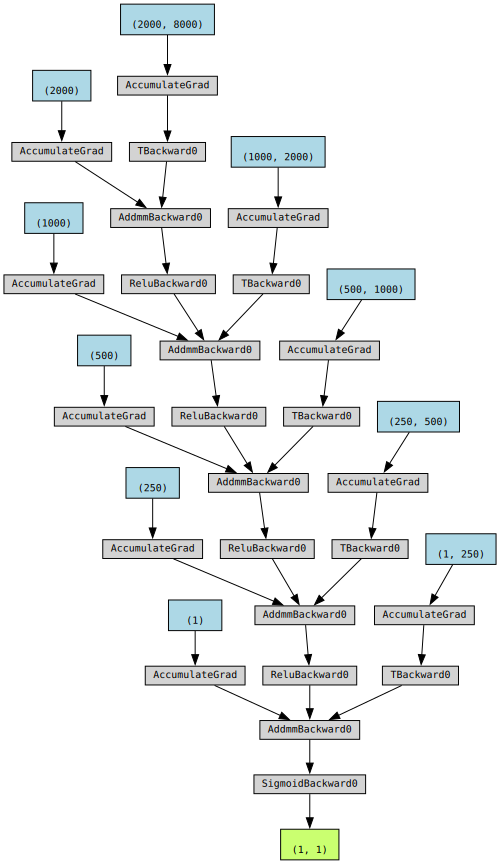

In [31]:
torchviz.make_dot(mlp_model(torch.rand((1, sampling_rate)).to(device)))

In [32]:
loss, accuracy, val_loss, val_accuracy = train(mlp_model, train_set, val_set, 30, 0.001, 0)

Epoch: 1/30 -- [1400/3128 (100.0%)]	Loss: 0.6936048102378846	Accuracy: 0.503	Time taken: 109.734375	Validation Loss: 0.6939125657081604 || Validation Accuracy: 0.460
Epoch: 2/30 -- [1400/3128 (100.0%)]	Loss: 0.6614820647239685	Accuracy: 0.588	Time taken: 91.640625	Validation Loss: 0.7040300369262695 || Validation Accuracy: 0.509
Epoch: 3/30 -- [1400/3128 (100.0%)]	Loss: 0.628465759754181	Accuracy: 0.623	Time taken: 88.046875	Validation Loss: 0.7129537463188171 || Validation Accuracy: 0.514
Epoch: 4/30 -- [1400/3128 (100.0%)]	Loss: 0.6037775301933288	Accuracy: 0.647	Time taken: 92.0625	Validation Loss: 0.7260467410087585 || Validation Accuracy: 0.487
Epoch: 5/30 -- [1400/3128 (100.0%)]	Loss: 0.5813436102867127	Accuracy: 0.668	Time taken: 88.25	Validation Loss: 0.7411409020423889 || Validation Accuracy: 0.501
Epoch: 6/30 -- [1400/3128 (100.0%)]	Loss: 0.566856038570404	Accuracy: 0.676	Time taken: 90.671875	Validation Loss: 0.7683586478233337 || Validation Accuracy: 0.496
Epoch: 7/30 -- [1

In [ ]:
plot_loss_acc(loss, accuracy, val_loss, val_accuracy, "MLP_Loss_Acc_1_{}".format(int(undersample)))

In [33]:
#torch.save(mlp_model, "mlp_model.onnx")
torch.onnx.export(mlp_model, torch.rand((1,8000)).to(device), "mlp_model.onnx")